In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
merged_df= pd.read_csv('GPA2.csv')

In [3]:
merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
0,2.04,920,1,10,4,40.000000,1
1,4.00,1170,0,940,191,20.319150,0
2,1.78,810,1,119,42,35.294120,0
3,2.42,940,0,571,252,44.133100,0
4,2.61,1180,0,214,86,40.186920,0
...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1
4131,2.46,900,0,10,2,20.000000,1
4132,4.00,1340,0,45,1,2.222222,0
4133,2.83,980,0,35,23,65.714290,1


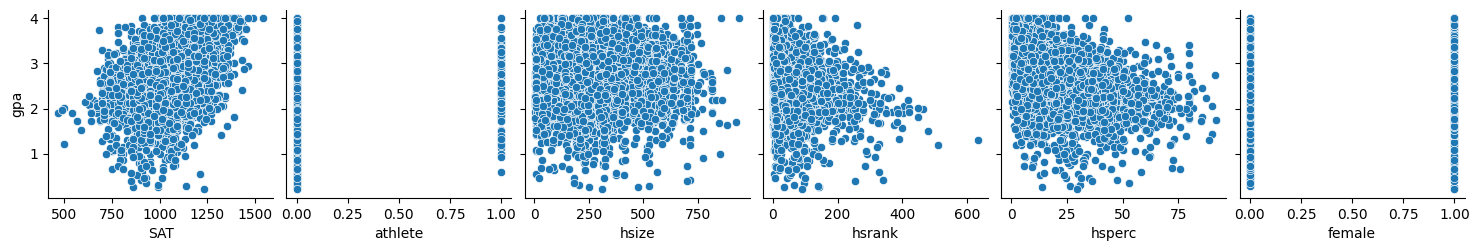

In [7]:
sns.pairplot(
    merged_df, 
    x_vars= ["SAT", "athlete","hsize","hsrank","hsperc","female"],
    y_vars= ['gpa']
)

Correlation Matrix:
              gpa       SAT   athlete     hsize    hsrank    hsperc    female
gpa      1.000000  0.410569 -0.092137 -0.026595 -0.333762 -0.428407  0.105971
SAT      0.410569  1.000000 -0.185102  0.063906 -0.177764 -0.283241 -0.153724
athlete -0.092137 -0.185102  1.000000  0.049433  0.188374  0.204964 -0.097164
hsize   -0.026595  0.063906  0.049433  1.000000  0.607410 -0.036213 -0.003756
hsrank  -0.333762 -0.177764  0.188374  0.607410  1.000000  0.611868 -0.104916
hsperc  -0.428407 -0.283241  0.204964 -0.036213  0.611868  1.000000 -0.146474
female   0.105971 -0.153724 -0.097164 -0.003756 -0.104916 -0.146474  1.000000


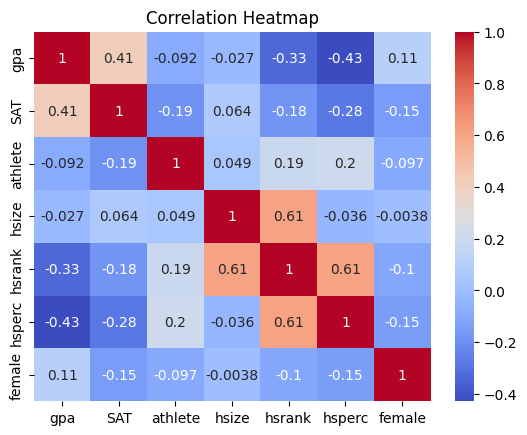

In [4]:
# Generate the correlation matrix
correlation_matrix = merged_df[['gpa', 'SAT', 'athlete','hsize','hsrank','hsperc','female']].corr()

# Print out the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [11]:
from sklearn.model_selection import cross_val_score

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Try a different random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Cross-validation RMSE scores: [0.52185647 0.53796659 0.57447333 0.56598062 0.56143505]
Mean CV RMSE: 0.5523424141968496
Train RMSE: 0.5537237876351424
Test RMSE: 0.5426327348911834
